In [1]:
from valpy.model import ValidationModel
import rudolfpy as rd
import numpy as np
import matplotlib.pyplot as plt

/Users/malavpatel/miniconda3/envs/sensortask/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
groundtruth_targets = np.array([[
        1.1540242813087864,
        0.0,
        -0.1384196144071876,
        4.06530060663289e-15,
        -0.21493019200956867,
        8.48098638414804e-15
    ]])
groundtruth_observers = np.array([[
        0.8027692908754149,
        0.0,
        0.0,
        -1.1309830924549648e-14,
        0.33765564334938736,
        0.0
    ]])

mu = 1.215058560962404e-02
LU = 384400
TU = 3.751902619517228e+05
VU = LU / TU

sigma_r0 = 100 / LU
sigma_v0 = 0.001 / VU

sigma_phi = np.deg2rad(0.1)
dt_meas = 3600/TU

estimate_observers = np.array([groundtruth_observers[0] + np.array([sigma_r0]*3 + [sigma_v0]*3) * np.random.normal(0, 1, 6)])
estimate_targets = np.array([groundtruth_targets[0] + np.array([sigma_r0]*3 + [sigma_v0]*3) * np.random.normal(0, 1, 6)])
P0_observers = np.array([np.diag([sigma_r0]*3 + [sigma_v0]*3)**2])
P0_targets = np.array([np.diag([sigma_r0]*3 + [sigma_v0]*3)**2])

dynamics = rd.DynamicsCR3BP(mu = mu, LU=LU, TU=TU, method='DOP853', rtol = 1e-12, atol = 1e-12)
meas_model = rd.MeasurementAngleAngleRate()
params_Q = [1e-5,]
filter = rd.ExtendedKalmanFilter(dynamics, meas_model,
                                 func_process_noise = rd.unbiased_random_process_3dof,
                                 params_Q = params_Q,)

timestep = 0.015

u = np.random.randint(low=0, high=2, size=(1, 1, 215))


In [3]:
vm = ValidationModel(u=u,
                     groundtruth_observers=groundtruth_observers,
                     groundtruth_targets=groundtruth_targets,
                     estimate_observers=estimate_observers,
                     estimate_targets=estimate_targets,
                     P0_observers=P0_observers,
                     P0_targets=P0_targets,
                     filter=filter,
                     timestep=timestep)

In [4]:
observer_idx = 0
t_measurements = np.linspace(0.05, 3.225, 10)
t_eval = np.linspace(0, 3.225, 100)
x_observer = [1.0 - mu, 0, 0, 0, 0, 0]
params_measurements = [[x_observer, sigma_phi, dt_meas]]*t_measurements.size

In [5]:
observer_history = vm._get_observer_history_filter(observer_idx=observer_idx,
                                params_measurements=params_measurements,
                                t_measurements=t_measurements,
                                t_eval=t_eval)
observer_history_gt = vm._get_observer_history_groundtruth(0, t_eval=t_eval)


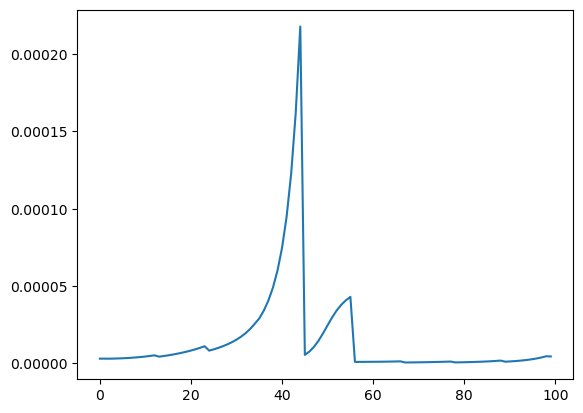

In [6]:
observer_history_trP = np.array([np.trace(item[1]) for item in observer_history])
plt.plot(observer_history_trP)

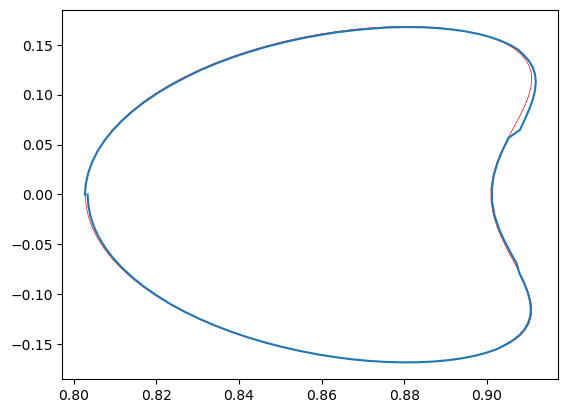

In [7]:
observer_history_r = np.array([item[0][:3] for item in observer_history])
observer_history_rgt = np.array([item[0][:3] for item in observer_history_gt])
plt.plot(observer_history_rgt[:,0], observer_history_rgt[:,1], color="red", linewidth=0.5)
plt.plot(observer_history_r[:,0], observer_history_r[:,1])

In [8]:
target_idx = 0
# t_eval = np.linspace(0, 3.225, 100)
t_eval = None
params_measurements = []

In [9]:
target_history = vm._get_target_history_filter(target_idx=target_idx,
                                               params_measurements=params_measurements,
                                               t_eval=t_eval)
target_history_gt = vm._get_target_history_groundtruth(target_idx=target_idx,
                                                       t_eval=t_eval)

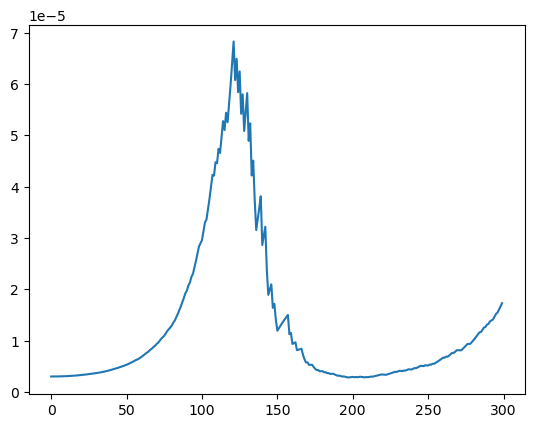

In [10]:
target_history_trP = np.array([np.trace(item[1]) for item in target_history])
plt.plot(target_history_trP)

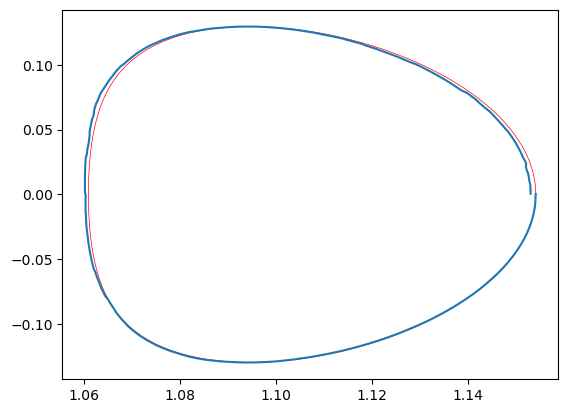

In [11]:
target_history_r = np.array([item[0][:3] for item in target_history])
target_history_rgt = np.array([item[0][:3] for item in target_history_gt])
plt.plot(target_history_rgt[:,0], target_history_rgt[:,1], color="red", linewidth=0.5)
plt.plot(target_history_r[:,0], target_history_r[:,1])